# Introduction to scvi-tools
In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on [data loading](data_loading.ipynb) for more examples.

* Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

<div class="alert alert-info">
Important

All scvi-tools models require AnnData objects as input. 

</div>

In [3]:
adata = scvi.data.heart_cell_atlas_subsampled()

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [4]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

<div class="alert alert-info">

Important

Unless otherwise specific, scvi-tools models require the raw counts.

</div>

In [5]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

In [6]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=1200, 
    subset=True, 
    layer="counts", 
    flavor="seurat_v3",
    batch_key="cell_source"
)

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group".
These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one covariate, you can also use the `batch_key` argument instead.

In [7]:
scvi.data.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor", "gender", "age_group"],
)

INFO     Using batches from adata.obs["cell_source"]                                         
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              


/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 4 batches,
         1 labels, and 0 proteins. Also registered 3 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


<div class="alert alert-warning">

Warning

If the adata is modified after running `setup_anndata`, please run `setup_anndata` again.

</div>

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [8]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it.

In [9]:
model

In [10]:
model.train()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 400/400: 100%|██████████| 400/400 [06:18<00:00,  1.06it/s, loss=285, v_num=1]


### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [12]:
model.save("my_model/")

In [13]:
model = scvi.model.SCVI.load("my_model/", adata, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs']                                                                         
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 4 batches,
         1 labels, and 0 proteins. Also registered 3 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_ca

## Obtaining model outputs

In [14]:
latent = model.get_latent_representation()

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [15]:
adata.obsm["X_scVI"] = latent

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [16]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(adata_subset)

INFO     Received view of anndata, making copy.                                              


In [17]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

INFO     Received view of anndata, making copy.                                              


,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.444758,0.002887,1.742146,0.015489,4.600572
GAGTCATTCTCCGTGT-1-HCAHeart8287128,0.741750,0.021758,1.266900,0.038884,35.987400
CCTCTGATCGTGACAT-1-HCAHeart7702881,0.797659,0.071539,1.363984,0.051847,1.416173
CGCCATTCATCATCTT-1-H0035_apex,0.163405,0.059732,0.722237,0.042146,13.772903
TCGTAGAGTAGGACTG-1-H0015_septum,0.154023,0.034434,0.191469,0.262325,11.145086


Let's store the normalized values back in the anndata.

In [18]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

## Interoperability with Scanpy

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

In [19]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

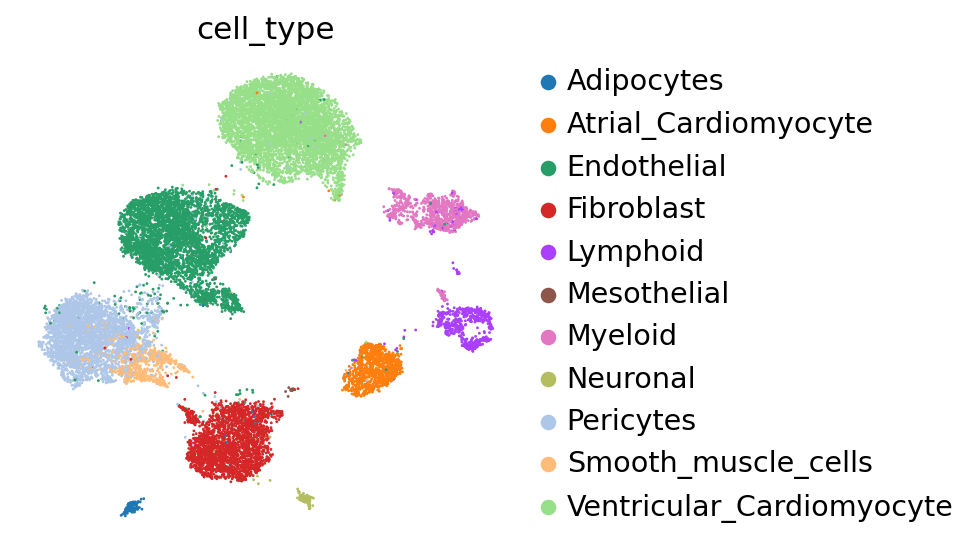

In [20]:
sc.pl.umap(
    adata, 
    color=["cell_type"], 
    frameon=False,
)

We can see that scVI was able to correct for nuisance variation due to nuclei/whole cell, age group, and donor, while maintaining separation of cell types.

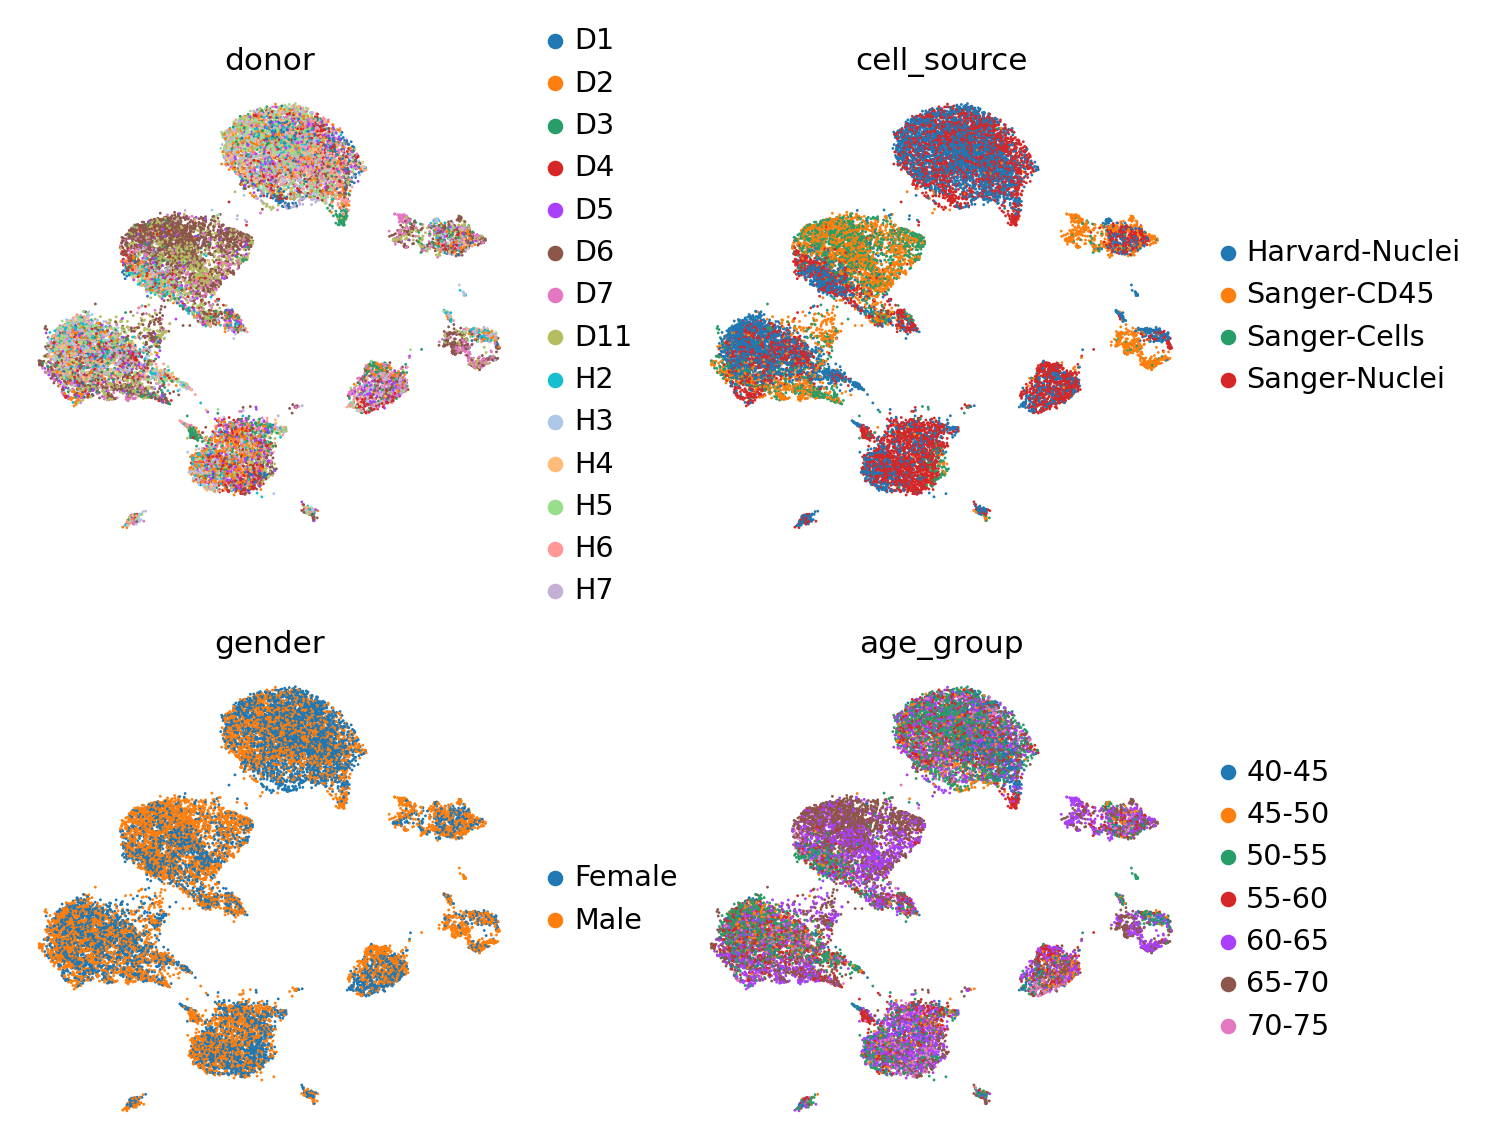

In [21]:
sc.pl.umap(
    adata, 
    color=["donor", "cell_source", "gender", "age_group"],
    ncols=2,
    frameon=False,
)

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI (e.g., for differential expression).

In [22]:
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)

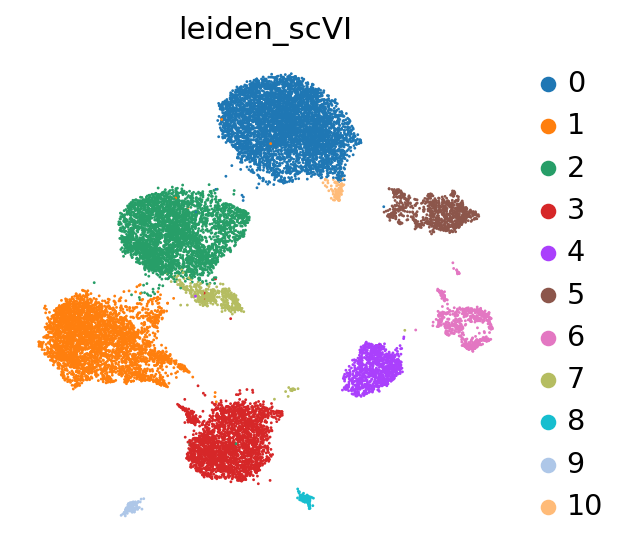

In [23]:
sc.pl.umap(
    adata, 
    color=["leiden_scVI"], 
    frameon=False,
)

## Differential expression
We can also use many scvi-tools models for differential expression. For further details on the methods underlying these functions as well as additional options, please see TODO.

In [24]:
adata.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ..., 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']

For example, a 1-vs-1 DE test is as simple as:

In [25]:
de_df = model.differential_expression(
    groupby="cell_type", 
    group1="Endothelial", 
    group2="Fibroblast"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
THBS2,0.9992,0.0008,7.130086,0.000023,0.001050,-6.789042,-6.880042,2.461202,-15.727278,2.471515,0.002920,0.284954,0.002677,0.155356,0.197070,12.048549,True,Endothelial vs Fibroblast
FGF7,0.9984,0.0016,6.436144,0.000080,0.001913,-4.800754,-4.800425,1.604995,-10.851135,2.129868,0.013385,0.417415,0.012412,0.216271,0.476594,20.070078,True,Endothelial vs Fibroblast
DCN,0.9984,0.0016,6.436144,0.000969,0.023185,-4.995236,-5.064736,1.723267,-10.798022,1.499433,0.108785,7.574429,0.073010,0.848733,7.380540,261.481750,True,Endothelial vs Fibroblast
CDH19,0.9984,0.0016,6.436144,0.000299,0.011935,-6.559155,-6.712720,2.097041,-13.603935,5.045513,0.049890,3.217938,0.014359,0.672527,1.843119,137.330276,True,Endothelial vs Fibroblast
ABCA10,0.9984,0.0016,6.436144,0.000092,0.006665,-7.582362,-7.875741,2.541099,-15.187826,5.863036,0.014359,1.282508,0.007788,0.499591,0.501825,69.613876,True,Endothelial vs Fibroblast


We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

In [26]:
de_df = model.differential_expression(
    groupby="cell_type", 
)
de_df.head()

DE...: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
GPAM,0.9994,0.0006,7.417964,0.026682,0.000193,7.521616,7.476966,2.342396,-1.903025,15.885991,17.372416,0.035791,0.896552,0.031520,280.340485,1.565905,True,Adipocytes vs Rest
FASN,0.9994,0.0006,7.417964,0.013085,0.000153,6.646603,6.685897,1.968999,0.042685,13.630307,7.062068,0.025086,0.841379,0.022167,129.074371,1.084626,True,Adipocytes vs Rest
GPD1,0.9984,0.0016,6.436144,0.003334,0.000054,7.162726,6.695196,3.103172,-3.318726,18.808504,1.758620,0.007353,0.620690,0.007299,30.203791,0.255079,True,Adipocytes vs Rest
PTPRF,0.9984,0.0016,6.436144,0.002594,0.000080,5.707150,5.691593,1.982277,-3.598483,12.724030,1.468965,0.011300,0.600000,0.010651,26.615402,0.438129,True,Adipocytes vs Rest
SLC19A3,0.9984,0.0016,6.436144,0.005161,0.000043,7.687081,7.752468,2.658379,-2.036440,16.299486,2.910343,0.004650,0.572414,0.004325,51.325165,0.268085,True,Adipocytes vs Rest


We now extract top markers for each cluster using the DE results.

In [27]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [28]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

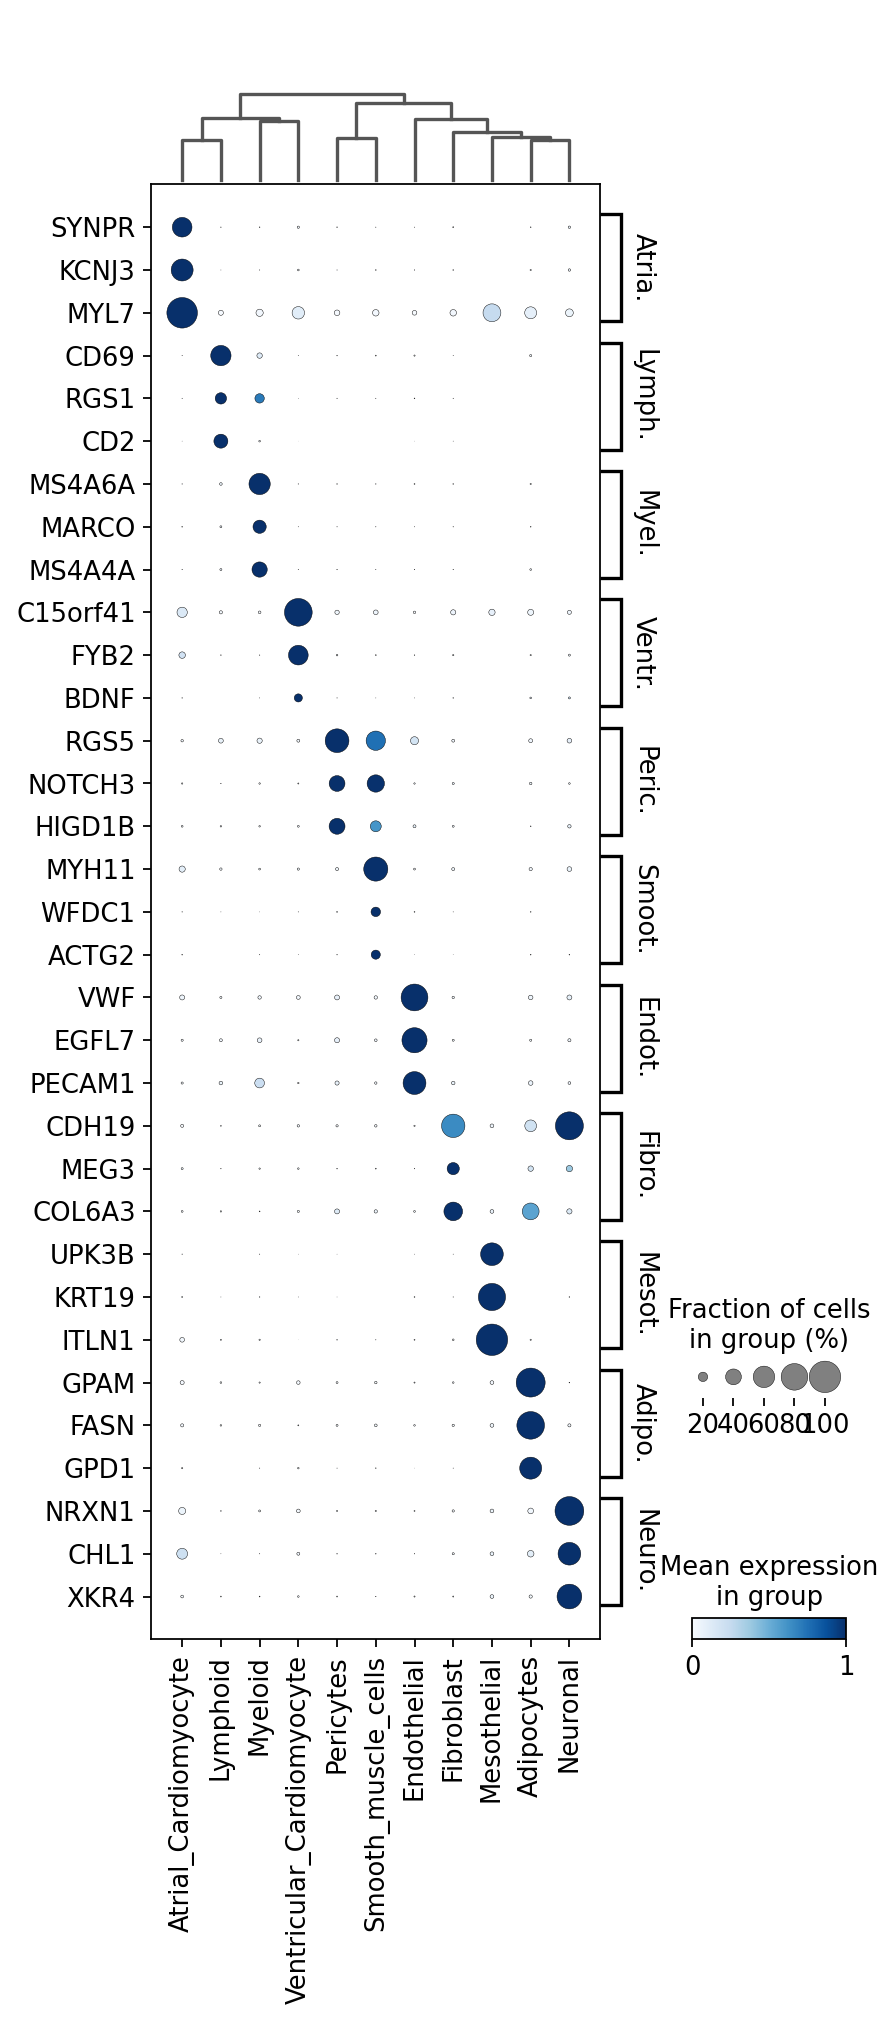

In [29]:
sc.pl.dotplot(
    adata, 
    markers, 
    groupby='cell_type', 
    dendrogram=True, 
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

We can also visualize the scVI normalized gene expression values with the `layer` option.

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


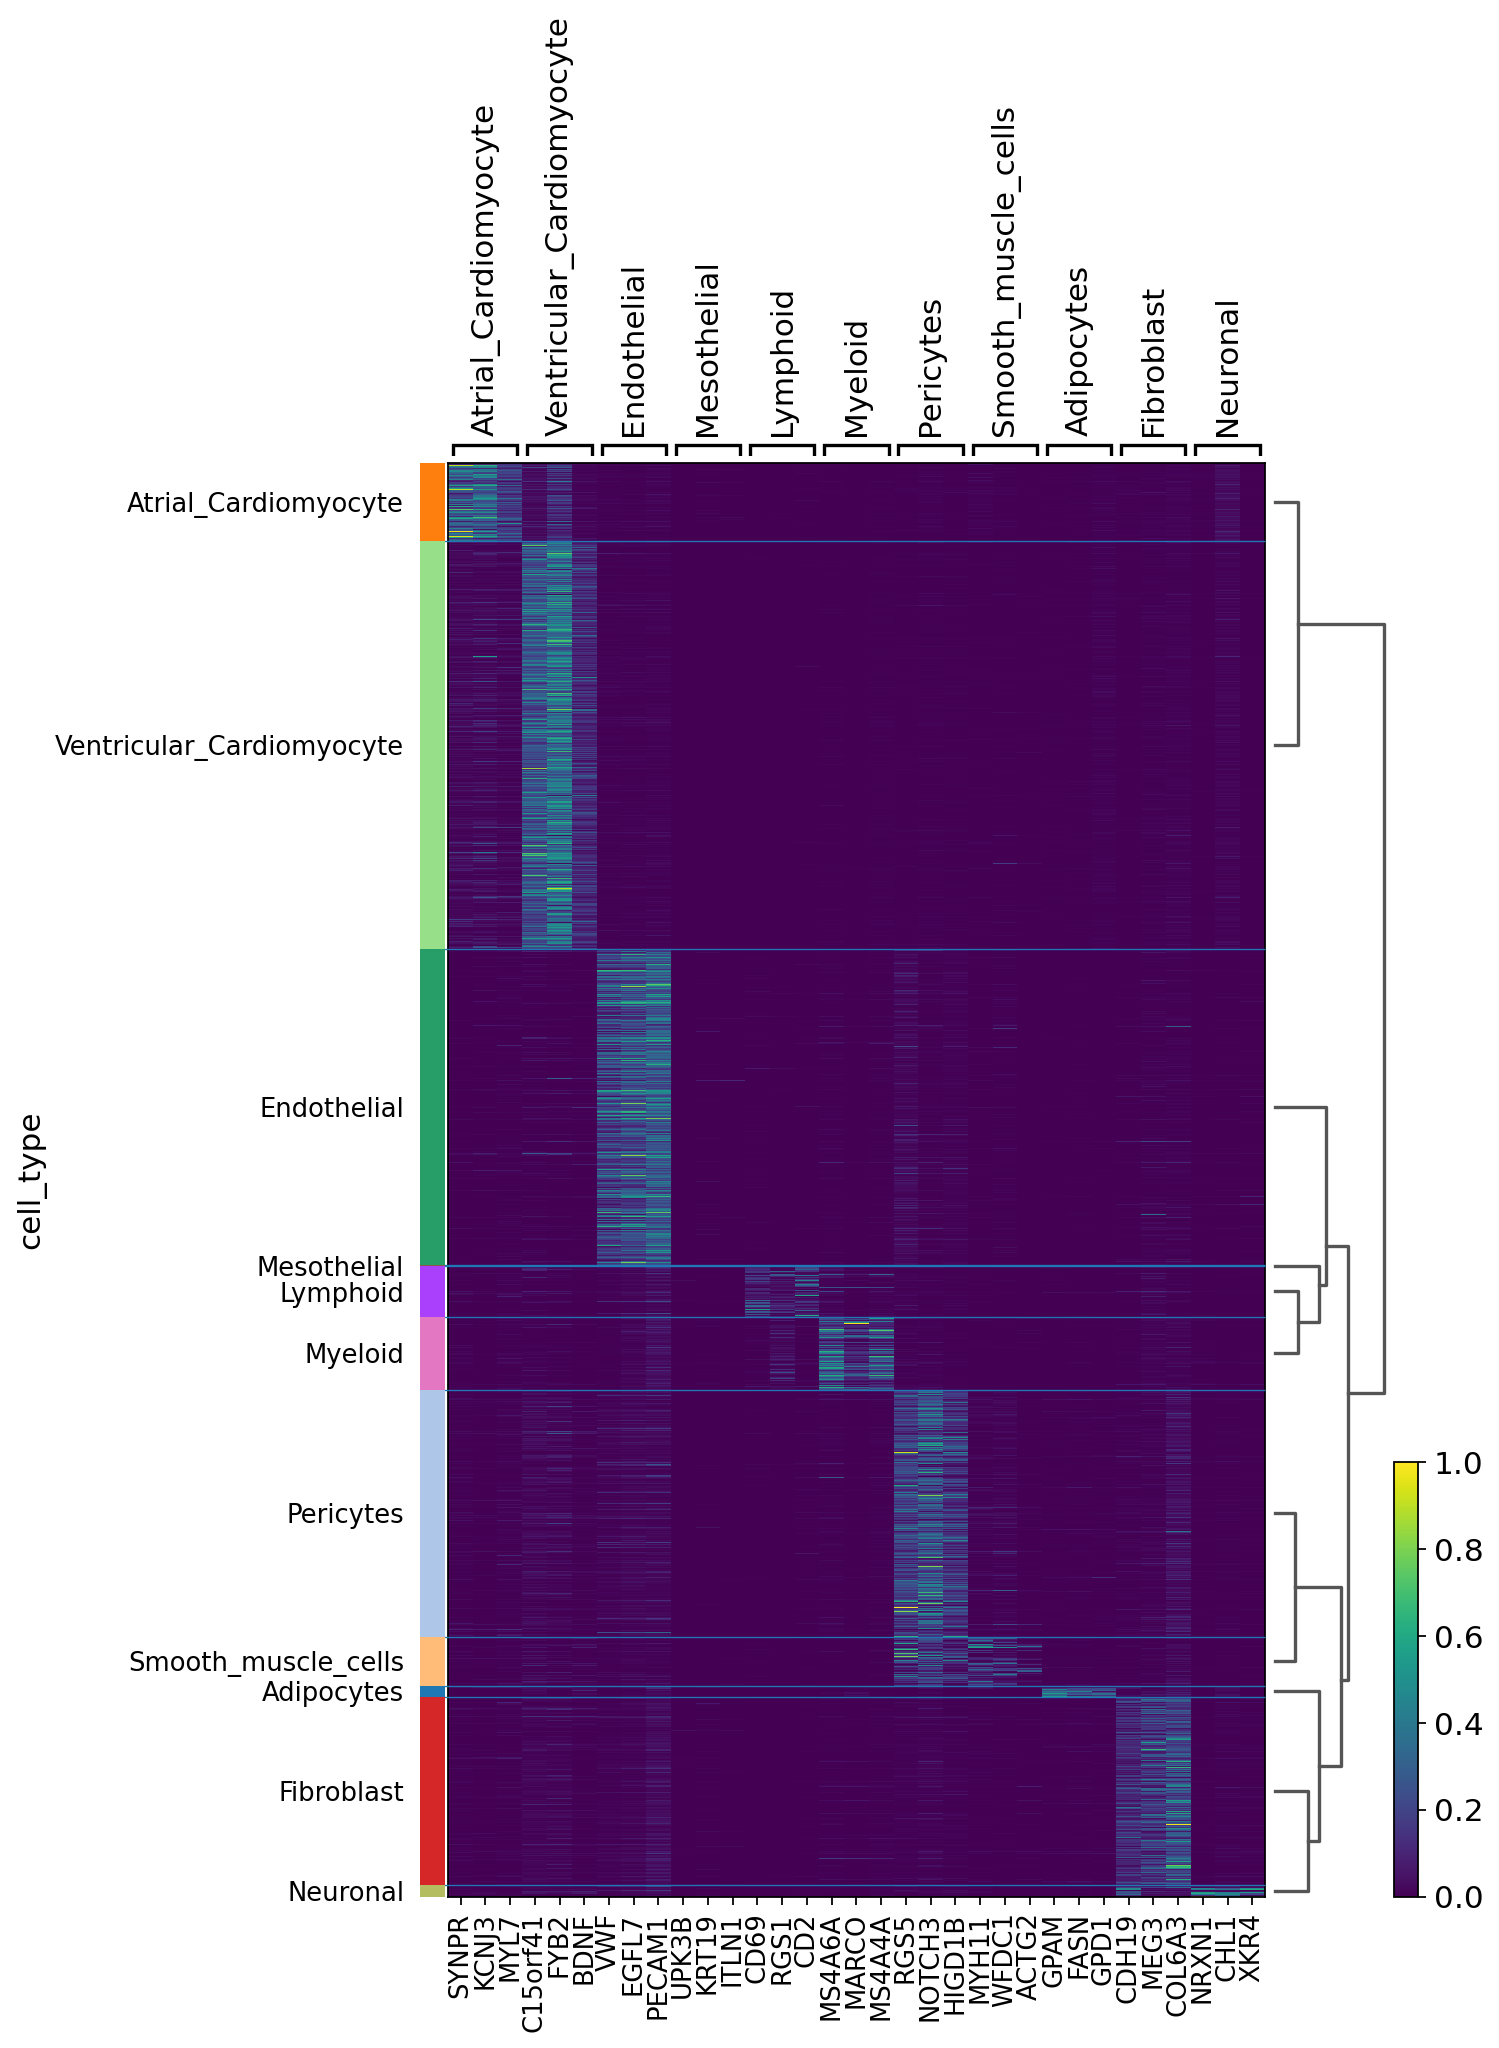

In [30]:
sc.pl.heatmap(
    adata, 
    markers, 
    groupby='cell_type', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

## Logging information

Verbosity varies in the following way:

* `logger.setLevel(logging.WARNING)` will show a progress bar.
* `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
* `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.settings.verbosity` to set the verbosity of the scvi package.
Note that `verbosity` corresponds to the logging levels of the standard python `logging` module. By default, that verbosity level is set to `INFO` (=20).
As a reminder the logging levels are:

<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>